In [ ]:
!unzip fashion-mnist.zip

#Preparar el dataset

In [ ]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

TRAIN_DATA_PATH = "./fashion-mnist/train/"
VALID_DATA_PATH = "./fashion-mnist/valid/"
TEST_DATA_PATH = "./fashion-mnist/test/"
DATA_TRANSFORM = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])
BATCH_SIZE = 32
train_data=datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=DATA_TRANSFORM)
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data=datasets.ImageFolder(root=VALID_DATA_PATH, transform=DATA_TRANSFORM)
valid_dl = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
X_valid, Y_valid = iter(valid_dl).next()
test_data=datasets.ImageFolder(root=TEST_DATA_PATH, transform=DATA_TRANSFORM)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
X_test, Y_test = iter(train_dl).next()

#Visualizar

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


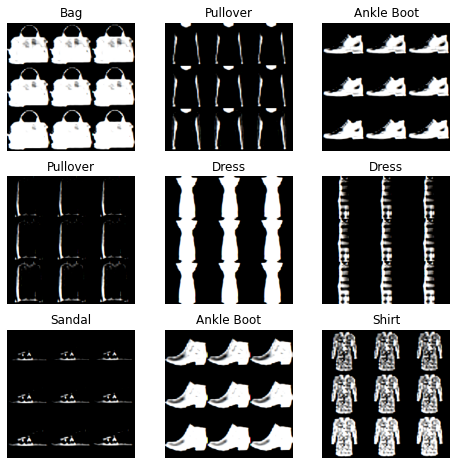

In [ ]:
import matplotlib.pyplot as plt
labels = {0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title(labels[int(Y_test[i])])
    plt.axis("off")
    plt.imshow(X_test[i].reshape(224,224,3))
plt.show()

#Cargar modelo CNN

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision', 'resnet152', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Adactar la capa de salida al dataset de Fashion-MNIST

In [ ]:
for p in model.parameters():
    p.requires_grad = False

out_dim = 10

model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)


model.load_state_dict(model.state_dict())

model.to(device)

#Descripcion del modelo
##ResNet-152 (pre-entrenado, modificado)
Se usa la arquitectura ResNet 152, pues es de las que mejores resultados (curvas de scores) obtiene en clasificacion de imagenes.

La arquitectura de ResNet152 tiene *4 stages*. La red puede tomar una imagen de entrada con altura y anchura múltiplos de 32 y 3 canales. En este caso 224 x 224 x 3.

La convolución inicial y max-pooling utilizan kernels de tamaño 7×7 y 3×3 respectivamente.

La Stage 1 de la red tiene 3 bloques residuales que contienen 3 capas cada uno con kernels de tamaño 64, 64 y 256 repectivamente.

La Stage 2 de la red tiene 8 bloques residuales que contienen 3 capas cada uno con kernels de tamaño 128, 128 y 512 repectivamente.

La Stage 3 de la red tiene 36 bloques residuales que contienen 3 capas cada uno con kernels de tamaño 556, 256 y 1024 repectivamente.

La Stage 4 de la red tiene 3 bloques residuales que contienen 3 capas cada uno con kernels de tamaño 512, 512 y 2048 repectivamente.

Finalmente, average-pooling.

#Entrenar el modelo

In [ ]:
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
loss_list = []
f1_list = []
acc_list = []
EPOCHS = 1
pbar = tqdm(total=EPOCHS*len(train_dl))
iter=0

model.train()
for epoch in range(EPOCHS):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    Xtr = X_train_batch
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)
    
    Y_pred = torch.argmax(Y_pred, 1)

    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
    
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    if iter%10 == 0:
      loss_list.append(loss)
      f1_list.append(f1)
      acc_list.append(acc)
    iter+=1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.update()
pbar.close()

  0%|          | 0/1719 [00:00<?, ?it/s]

#Graficar los Scores

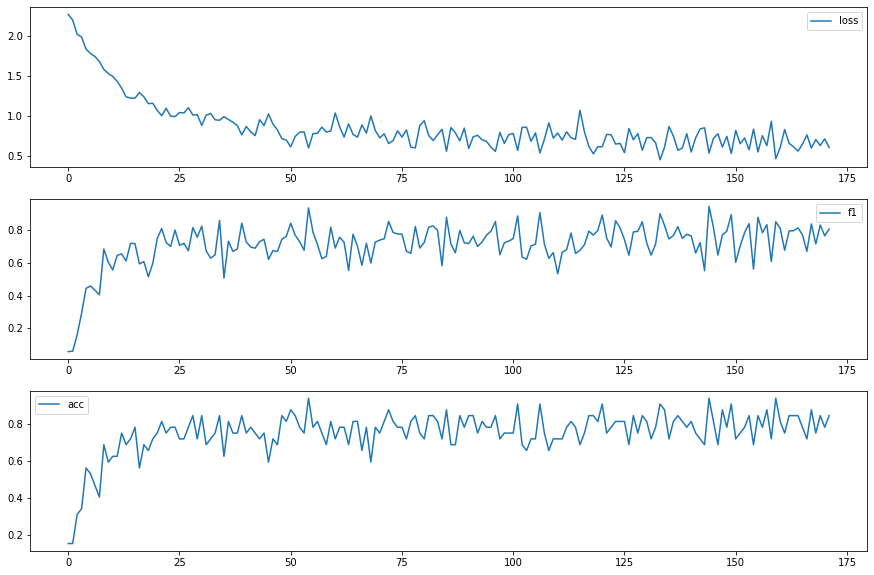

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
plt.legend()

#Evaluar el modelo

In [ ]:
X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.69, F1:0.70, Acc:0.72


#Matrix de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def CM(Y_true, Y_pred, classes: int):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

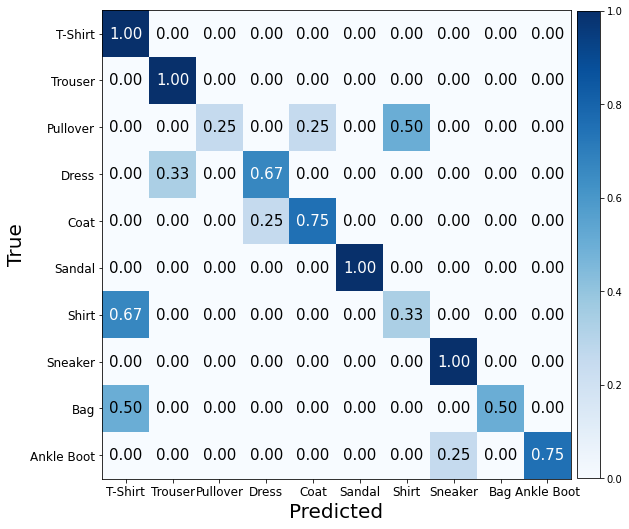

In [ ]:
CM(Y_valid.cpu(), Y_pred.cpu(), 10)

#Conclusiones
Al usar una arquitectura entrenada ahorramos tanto tiempo en el diseño como recursos para entrenarla beneficiandonos las muchas caracteristica que ya ha aprendido.